In [1]:
from alpdesign.utils import *
from alpdesign.mlp import *
from jax_unirep import get_reps
import alpdesign
import numpy as np
import matplotlib.pyplot as plt
import jax_unirep
import haiku as hk
import jax
import jax.numpy as jnp
import functools
from sklearn.decomposition import PCA

In [49]:
AA_list = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V','B','Z','X','*']
blosum92 = np.loadtxt("./blosum62.txt", dtype='i', delimiter=' ')
def blosum(seq1, seq2):
    seqlist1 = list(seq1)
    seqlist2 = list(seq2)
    score = 0.
    for i in range(len(seqlist1)):
        idx1 = AA_list.index(seqlist1[i])
        idx2 = AA_list.index(seqlist2[i])
        score += blosum92[idx1][idx2]
    return jax.nn.sigmoid(score/len(seqlist1))

In [87]:
target_seq = 'GIGAVLKVLT'
oh_vec = encode_seq(list(target_seq))
oh_unirep = seq2useq(oh_vec)
target_rep = differentiable_jax_unirep(oh_unirep)
'''
seqs = ['GIGAVLKVLKAGLPALIVTLKRKIVQ',
       'PPGATLKKHTTGSVALISWIWARIQQ',
       'GIGAVLKVLTTGLKTLISAAKRKRAA',
       'HAPPVLKVLTTGLAPPLVWIKRKRTH',
       'GIGAVLUIHKLSSVAAWRPPKRKRQQ',
       'PTWIIFLKAQWEQHSNLTNMRTFPEV',
        'TISHFVCNHDICAWIKDMQAMQIKMC',
        'CESWLWKRLFDGHADRWRSMPDYPIW',
        'YLVENPLMFPLVAAFIHQWTRQISWH',
        'QTEERLEAQISIYYIGAWSHYKVTDE']
'''

seqs = ['SSVAAWRPPK',
       'PPGATLKKHT',
       'LTGAVLKVLK',
       'HAPPVLKVLT',
       'AWRPPKRKRQ',
       'PTWIIFLKAQ',
       'TISHFVCNHD',
       'CESWLWKRLF',
       'YLVENPLMFP',
       'QTEERLEAQI',
       'GAWSHYKVTD',
       'HADRWRSMPD']
reps = get_reps(seqs)[0]
labels = []
for seq in seqs:
    labels.append(blosum(target_seq, seq))
labels = np.array(labels)
print(labels)

[0.33181223 0.8021839  0.9241418  0.880797   0.21416503 0.2890505
 0.26894143 0.3543437  0.21416503 0.33181223 0.66818774 0.21416503]


In [91]:
key = jax.random.PRNGKey(0)
class NaiveBlock(hk.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
    
    def __call__(self, x):
        out = hk.nets.MLP((256, 128, 64, 1,))(x)
        return out
    
def naive_forward(x):
    f = NaiveBlock()
    return f(x)
naive_forward_t = hk.without_apply_rng(hk.transform(naive_forward))

In [96]:
def _naive_loss(forward, params, seq, label):
    yhat = forward(params, seq) #scalar
    return (label-yhat)**2

def _shuffle_in_unison(key, a, b):
    # NOTE to future self: do not try to rely on keys being same
    # something about shape of arrays makes shuffle not the same
    assert len(a) == len(b)
    p = jax.random.permutation(key, len(a))
    return jnp.array([a[i] for i in p]), jnp.array([b[i] for i in p])


def _fill_to_batch(x, y, key, batch_size):
    if len(y) >= batch_size:
        return x, y
    i = jax.random.choice(key, jnp.arange(len(y)),
                          shape=(batch_size,), replace=True)
    x = x[i, ...]
    y = y[i, ...]
    return x, y


def naive_train(key, forward_t, seqs, labels, val_seqs=None, val_labels=None, params=None, epochs=3, batch_size=8, learning_rate=1e-2):
    opt_init, opt_update = optax.chain(
        optax.scale_by_adam(b1=0.8, b2=0.9, eps=1e-4),
        optax.scale(-learning_rate)  # minus sign -- minimizing the loss
    )

    key, bkey = jax.random.split(key)

    # fill in seqs/labels if too small
    seqs, labels = _fill_to_batch(seqs, labels, bkey, batch_size)
   
        
    if params == None:
        params = forward_t.init(key, seqs[0])
  
    opt_state = opt_init(params)

    # wrap loss in batch/sum
    loss_ = partial(_naive_loss, forward_t.apply)
    loss_fxn = lambda *args: jnp.mean(jax.vmap(loss_, in_axes=(None, 0, 0))(*args))
    #loss_fxn = jnp.mean(jax.vmap(loss_, in_axes=(None, 0, 0)))

    @jax.jit
    def train_step(opt_state, params, seqs, labels):
        loss, grad = jax.value_and_grad(loss_fxn, 0)(
            params, seqs, labels)
        updates, opt_state = opt_update(grad, opt_state, params)
        params = optax.apply_updates(params, updates)
        return opt_state, params, loss
    losses = []
    val_losses = []
    for e in range(epochs):
        # shuffle seqs and labels
        key, key_ = jax.random.split(key, num=2)
        shuffle_seqs, shuffle_labels = _shuffle_in_unison(key, seqs, labels)
        for i in range(0, len(shuffle_labels) // batch_size):
            seq = shuffle_seqs[i:(i+1) * batch_size]
            label = shuffle_labels[i:(i+1) * batch_size]
            opt_state, params, loss = train_step(opt_state, params, seq, label)
            losses.append(loss)
        # compute validation loss
        if val_seqs is not None:
            val_loss = 0.
            for i in range(0, len(val_labels) // batch_size):
                seq = shuffle_seqs[i:(i+1) * batch_size]
                label = shuffle_seqs[i:(i+1) * batch_size]
                val_loss += loss_fxn(
                    params,
                    val_seqs[i:(i+1) * batch_size],
                    val_labels[i:(i+1) * batch_size])
            val_loss = val_loss/len(val_labels) * batch_size
            #batch_loss += loss
            val_losses.append(val_loss)
    return (params, losses) if val_seqs is None else (params, losses, val_losses)

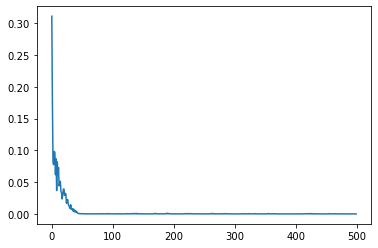

In [97]:
params, losses = naive_train(
    key, naive_forward_t, reps, labels, epochs=160, learning_rate=1e-3)
#forward_t = hk.without_apply_rng(hk.transform(forward_fxn))
#forward = functools.partial(forward_t.apply, params)
plt.plot(losses)

In [119]:
def e2e(logits): # params is trained mlp params
    s = alpdesign.SeqpropBlock()(logits)
    us = alpdesign.seq2useq(s)
    u = alpdesign.differentiable_jax_unirep(us)
    return naive_forward(u)
e2e_t = hk.transform(e2e)
init_logits = jax.random.normal(key, shape=((10, 20)))
e2e_params = e2e_t.init(key, init_logits)

def e2e_fxn(x, key):
    e2e_params, logits = x
    yhat = e2e_t.apply(e2e_params, key, logits)
    return yhat


def gradient_opt(key, f, init_x=None, iter_num=500, learning_rate=1e-2):
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(init_x)
    x = init_x
    reduced_f = lambda *args: jnp.mean(f(*args))
    
    @jax.jit
    def step(x, opt_state, key):
        loss, g = jax.value_and_grad(reduced_f, 0)(x, key)
        updates, opt_state = optimizer.update(g, opt_state)
        x = optax.apply_updates(x, updates)
        return x, opt_state, loss
    losses = []
    for step_idx in range(iter_num):
        key, _ = jax.random.split(key, num=2)
        x, opt_state, loss= step(x, opt_state, key)
        losses.append(loss)
            
    return x, losses

In [ ]:
batch_size = 5
BO_batch_size = 16
reps = get_reps(seqs)[0]
labels = []
for seq in seqs:
    labels.append(blosum(target_seq, seq))
labels = np.array(labels)
def loop(key, reps, labels, params):
    key, train_key = jax.random.split(key, num=2)
    #reps = get_reps(seqs)[0]
    '''
    labels = []
    for seq in seqs:
        labels.append(blosum(target_seq, seq))
    labels = np.array(labels)
    '''
    params, losses = naive_train(
    key, naive_forward_t, reps, labels, epochs=500, learning_rate=1e-3)
    #params, losses = alpdesign.ensemble_train(train_key, full_forward_t, c, reps, labels, params=params, epochs=100)
    # make random point
    init_logits = jax.random.normal(key, shape=((10, 20)))
    key, train_key = jax.random.split(key, num=2)
    init_x = 0.1*jax.random.normal(key, shape=(BO_batch_size, 10, 20))
    #forward = jax.vmap(lambda x, key: forward_t.apply(params, x), in_axes=(0, None))
    print('start Optimizing')
    #batch_e2e = jax.vmap(lambda x, key: e2e_fxn(params, x), in_axes=((None, 0), None))
    batch_e2e = jax.vmap(e2e_fxn, ((None, 0), None))
    batched_x, losses = gradient_opt(key, batch_e2e, (e2e_t.init(train_key, init_logits), init_x))
    top_idx = np.argmin(losses[-1])
    rb = batched_x[0]
    batched_logits = batched_x[1]
    final_logits = batched_logits[top_idx]
    vec = alpdesign.seq.forward_seqprop.apply(rb, key, final_logits)
    s = decode_seq(vec)
    reps = np.concatenate((reps, get_reps([s])[0]))
    
    y = blosum(target_seq, s)
    print(reps.shape)
    print(s, y)
    labels = np.concatenate((labels, np.array(y).reshape(1,)))
    '''
    plt.figure()
    proj_x = pca.transform(reps)
    #print(proj_x)
    plt.scatter(proj_x[:,0], proj_x[:,1], c=labels, cmap=plt.get_cmap('Reds'))
    plt.colorbar()
    proj_l = pca.transform(target_rep)
    plt.plot(proj_l[:,0], proj_l[:,1], 'p')
    plt.plot(proj_x[-1, 0], proj_x[-1, 1], 'o', color='green')    
    plt.show()
    
    '''
    return key, reps, labels, s, params

In [ ]:
key = jax.random.PRNGKey(0)
params = None
for i in range(20):
    print(i)
    key, reps, labels, final_vec, params= loop(key, reps, labels, params)
    print(final_vec)

0
start BO
(13, 1900)
['P', 'C', 'C', 'A', 'C', 'C', 'A', 'C', 'A', 'C'] 0.3100255
['P', 'C', 'C', 'A', 'C', 'C', 'A', 'C', 'A', 'C']
1
start BO
(14, 1900)
['C', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P'] 0.10909683
['C', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P']
2
start BO
(15, 1900)
['C', 'A', 'A', 'P', 'A', 'A', 'P', 'A', 'P', 'P'] 0.24973989
['C', 'A', 'A', 'P', 'A', 'A', 'P', 'A', 'P', 'P']
3
start BO
(16, 1900)
['C', 'P', 'P', 'P', 'A', 'P', 'P', 'A', 'P', 'P'] 0.15446526
['C', 'P', 'P', 'P', 'A', 'P', 'P', 'A', 'P', 'P']
4
start BO
(17, 1900)
['C', 'P', 'P', 'P', 'A', 'P', 'P', 'P', 'P', 'P'] 0.13010848
['C', 'P', 'P', 'P', 'A', 'P', 'P', 'P', 'P', 'P']
5
start BO
(18, 1900)
['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'] 0.18242553
['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']
6
start BO
